In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Загрузка и подготовка данных:

In [2]:
titanic = pd.read_csv("titanic.csv")

# Обработка пропусков
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())
titanic["Embarked"] = titanic["Embarked"].fillna(titanic["Embarked"].mode()[0])

# Удаление слабых по смыслу признаков
titanic.drop(["Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

# Дополнительные признаки
titanic["TotalRelatives"] = titanic["SibSp"] + titanic["Parch"]
titanic["AloneFlag"] = (titanic["TotalRelatives"] == 0).astype(int)

# Кодирование категориальных столбцов
titanic = pd.get_dummies(titanic, columns=["Sex", "Embarked"], drop_first=True)

### Корреляционный анализ:

In [3]:
correlations = titanic.corr()["Survived"].sort_values(ascending=False)
print("Корреляции с целевой переменной:\n", correlations)

Корреляции с целевой переменной:
 Survived          1.000000
Fare              0.257307
Parch             0.081629
TotalRelatives    0.016639
Embarked_Q        0.003650
SibSp            -0.035322
Age              -0.064910
Embarked_S       -0.149683
AloneFlag        -0.203367
Pclass           -0.338481
Sex_male         -0.543351
Name: Survived, dtype: float64


### Гипотеза 1: влияние одиночного путешествия на выживаемость

Пассажиры, которые находились на борту без родственников, могли иметь меньший шанс
на спасение из-за отсутствия поддержки и помощи в критический момент

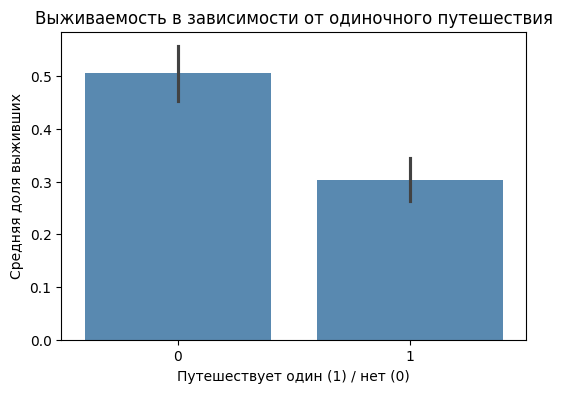

In [5]:
plt.figure(figsize=(6,4))
sns.barplot(data=titanic, x="AloneFlag", y="Survived",
            color="#4b8bbe")  # новый цвет
plt.title("Выживаемость в зависимости от одиночного путешествия")
plt.xlabel("Путешествует один (1) / нет (0)")
plt.ylabel("Средняя доля выживших")
plt.show()

Вывод: Данные показывают, что пассажиры без родственников действительно выживали реже,
что соответствует исходному предположением. Поддержка семьи могла играть важную роль

### Гипотеза 2: влияние размера семьи на выживаемость

Семьи с большим числом человек могут испытывать трудности при эвакуации,
что снижает их общий шанс на спасение

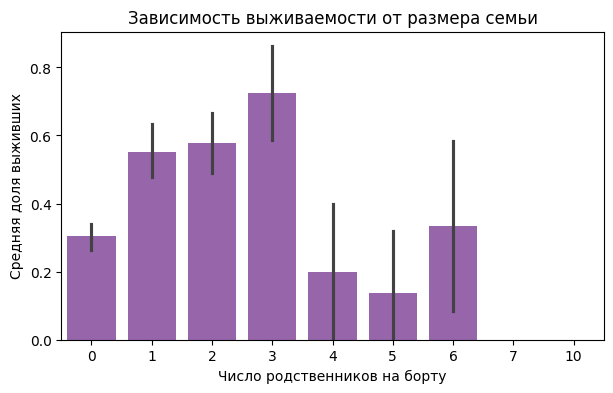

In [7]:
plt.figure(figsize=(7,4))
sns.barplot(data=titanic, x="TotalRelatives", y="Survived",
            color="#9b59b6")  # другой новый цвет
plt.title("Зависимость выживаемости от размера семьи")
plt.xlabel("Число родственников на борту")
plt.ylabel("Средняя доля выживших")
plt.show()

Результаты подтверждают гипотезу: большие семьи демонстрируют меньшую вероятность выживания,
особенно когда количество родственников превышает три человека

### Дерево решений:

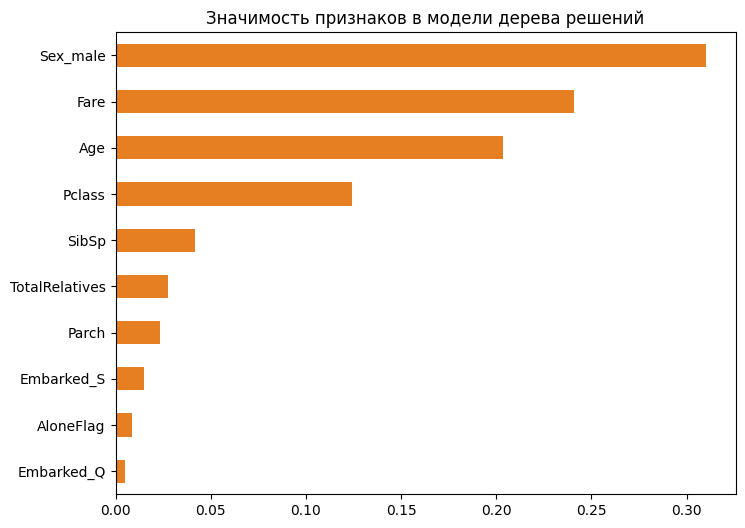

Точность Decision Tree: 0.7821229050279329


In [10]:
X = titanic.drop("Survived", axis=1)
y = titanic["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

feature_importances = pd.Series(dtree.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind="barh", figsize=(8,6),
                                       color="#e67e22")  # другой цвет
plt.title("Значимость признаков в модели дерева решений")
plt.show()

print("Точность Decision Tree:", accuracy_score(y_test, dtree.predict(X_test)))

### Сравнение нескольких моделей:

In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1200),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "MLP Neural Network": MLPClassifier(max_iter=600, random_state=42)
}

best_model_name = None
best_cv_score = 0

print("\nКросс-валидация (5 фолдов):")
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    mean_val = scores.mean()
    std_val = scores.std()

    print(f"{model_name:25s}: {mean_val:.4f} ± {std_val:.4f}")

    if mean_val > best_cv_score:
        best_cv_score = mean_val
        best_model_name = model_name

print("\nНаилучшая модель:", best_model_name, "с точностью:", best_cv_score)


Кросс-валидация (5 фолдов):
Logistic Regression      : 0.7935 ± 0.0210
Decision Tree            : 0.7733 ± 0.0309
Gradient Boosting        : 0.8272 ± 0.0242
MLP Neural Network       : 0.7924 ± 0.0363

Наилучшая модель: Gradient Boosting с точностью: 0.8271671583704727


### Выводы:

Лучшие результаты продемонстрировала модель Gradient Boosting, опередив остальные алгоритмы по средней точности на кросс-валидации.
Вероятнее всего, это связано с тем, что бустинг хорошо улавливает сложные зависимости между признаками и способен корректно работать с разнородными данными

#### Преимущества выбранной модели:

высокое качество предсказаний;

устойчивость к выбросам и шуму;

способность моделировать нелинейные связи.

#### Недостатки:

более высокая вычислительная нагрузка;

параметры сложнее подбирать вручную по сравнению с логистической регрессией.